# Some simple demos of approaches to Bayesian inference with unknown errors

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


## Treat the error as a parameter

In [6]:
def log_posterior(y, x, m, b, sigma2, m_prior, b_prior, sigma2_prior):
    """
    Calculate the log posterior given parameters.
    """
    # Log likelihood
    residuals = y - (m * x + b)
    log_likelihood = -0.5 * np.sum(residuals**2 / sigma2) - (len(y) / 2) * np.log(
        2 * np.pi * sigma2
    )

    # Log priors
    log_prior_m = norm.logpdf(m, loc=m_prior[0], scale=np.sqrt(m_prior[1]))
    log_prior_b = norm.logpdf(b, loc=b_prior[0], scale=np.sqrt(b_prior[1]))
    log_prior_sigma2 = invgamma.logpdf(sigma2, a=sigma2_prior[0], scale=sigma2_prior[1])

    return log_likelihood + log_prior_m + log_prior_b + log_prior_sigma2

In [7]:
def metropolis_hastings(
    y,
    x,
    n_iterations=1000,
    burn_in=200,
    m_prior=(0, 10),
    b_prior=(0, 10),
    sigma2_prior=(1, 1),
    proposal_std=(0.1, 0.1, 0.1),
):
    # Proposal distribution std deviation
    prop_m, prop_b, prop_log_sigma2 = proposal_std

    # Initialization
    m_current = np.random.normal(m_prior[0], np.sqrt(m_prior[1]))
    b_current = np.random.normal(b_prior[0], np.sqrt(b_prior[1]))
    sigma2_current = invgamma.rvs(a=sigma2_prior[0], scale=sigma2_prior[1])

    # Storage for samples
    m_samples = []
    b_samples = []
    sigma2_samples = []

    # Current log posterior
    current_log_post = log_posterior(
        y, x, m_current, b_current, sigma2_current, m_prior, b_prior, sigma2_prior
    )

    accepted = 0
    for iteration in range(n_iterations):
        # Propose new m and b
        m_proposal = m_current + np.random.normal(0, prop_m)
        b_proposal = b_current + np.random.normal(0, prop_b)
        # Propose new sigma^2 using log proposal (ensures positivity)
        log_sigma2_proposal = np.log(sigma2_current) + np.random.normal(
            0, prop_log_sigma2
        )
        sigma2_proposal = np.exp(log_sigma2_proposal)

        # Calculate log posterior for proposed values
        proposed_log_post = log_posterior(
            y,
            x,
            m_proposal,
            b_proposal,
            sigma2_proposal,
            m_prior,
            b_prior,
            sigma2_prior,
        )

        # Acceptance probability
        acceptance_prob = np.exp(proposed_log_post - current_log_post)
        # Accept or reject
        if np.random.rand() < acceptance_prob:
            m_current, b_current, sigma2_current = (
                m_proposal,
                b_proposal,
                sigma2_proposal,
            )
            current_log_post = proposed_log_post
            accepted += 1

        # Store samples after burn-in
        if iteration >= burn_in:
            m_samples.append(m_current)
            b_samples.append(b_current)
            sigma2_samples.append(sigma2_current)

    return m_samples, b_samples, sigma2_samples, accepted / (n_iterations - burn_in)

In [8]:
x_data = np.random.normal(0, 1, 100)
y_data = 3.0 * x_data + 4.0 + np.random.normal(0, np.sqrt(2), 100)

# Define priors: (mean, variance) for normal, (alpha, beta) for inverse gamma
m_prior = (4, 3)
b_prior = (3, 3)
sigma2_prior = (0.3, 3)

# Run Metropolis-Hastings
m_samples, b_samples, sigma2_samples, afrac = metropolis_hastings(
    y_data,
    x_data,
    m_prior=m_prior,
    b_prior=b_prior,
    sigma2_prior=sigma2_prior,
    proposal_std=(0.1, 0.1, 0.1),
    n_iterations=10000,
)
print(f"acceptance frac: {afrac}")
print("Estimated m:", np.mean(m_samples))
print("Estimated b:", np.mean(b_samples))
print("Estimated sigma^2:", np.mean(sigma2_samples))

acceptance frac: 0.5942857142857143
Estimated m: 3.1293800012827444
Estimated b: 3.9349835021456254
Estimated sigma^2: 2.228075851925056


## Alternate sampling error and model parameters in batches
This is useful when evaluating the model is compuationall expensive relative to evaluting the log likelihood conditional on a given model prediction

In [9]:
def log_posterior_batch(y, y_model, sigma2, m_prior, b_prior, sigma2_prior):
    """
    Calculate the log posterior given parameters, considering fixed y_model.
    """
    # Log likelihood
    residuals = y - y_model
    log_likelihood = -0.5 * np.sum(residuals**2 / sigma2) - (len(y) / 2) * np.log(
        2 * np.pi * sigma2
    )

    # Assuming m_prior and b_prior are already incorporated during m and b updates
    # Log prior for sigma^2
    log_prior_sigma2 = invgamma.logpdf(sigma2, a=sigma2_prior[0], scale=sigma2_prior[1])

    return log_likelihood + log_prior_sigma2

In [10]:
def metropolis_hastings_batched(
    y,
    x,
    n_iterations=1000,
    burn_in=200,
    batch_size=10,
    m_prior=(0, 10),
    b_prior=(0, 10),
    sigma2_prior=(1, 1),
    proposal_std=(0.1, 0.1, 0.1),
):
    prop_m, prop_b, prop_log_sigma2 = proposal_std

    # Initialization
    m_current = np.random.normal(m_prior[0], np.sqrt(m_prior[1]))
    b_current = np.random.normal(b_prior[0], np.sqrt(b_prior[1]))
    sigma2_current = invgamma.rvs(a=sigma2_prior[0], scale=sigma2_prior[1])
    y_model = m_current * x + b_current

    # Storage for samples
    m_samples = []
    b_samples = []
    sigma2_samples = []
    accepted = 0
    for iteration in range(n_iterations):
        if iteration % (2 * batch_size) < batch_size:
            # Update m and b
            m_proposal = m_current + np.random.normal(0, prop_m)
            b_proposal = b_current + np.random.normal(0, prop_b)
            y_model_proposal = m_proposal * x + b_proposal

            # Calculate and compare log posterior
            current_log_post = log_posterior_batch(
                y, y_model, sigma2_current, m_prior, b_prior, sigma2_prior
            )
            proposed_log_post = log_posterior_batch(
                y, y_model_proposal, sigma2_current, m_prior, b_prior, sigma2_prior
            )

            acceptance_prob = np.exp(proposed_log_post - current_log_post)
            if np.random.rand() < acceptance_prob:
                m_current, b_current, y_model = m_proposal, b_proposal, y_model_proposal
                accepted += 1

        else:
            # Update sigma^2
            log_sigma2_proposal = np.log(sigma2_current) + np.random.normal(
                0, prop_log_sigma2
            )
            sigma2_proposal = np.exp(log_sigma2_proposal)

            # Calculate and compare log posterior (holding m and b fixed)
            current_log_post = log_posterior_batch(
                y, y_model, sigma2_current, m_prior, b_prior, sigma2_prior
            )
            proposed_log_post = log_posterior_batch(
                y, y_model, sigma2_proposal, m_prior, b_prior, sigma2_prior
            )

            acceptance_prob = np.exp(proposed_log_post - current_log_post)
            if np.random.rand() < acceptance_prob:
                sigma2_current = sigma2_proposal
                accepted += 1

        # Store samples after burn-in
        if iteration >= burn_in:
            m_samples.append(m_current)
            b_samples.append(b_current)
            sigma2_samples.append(sigma2_current)

    return m_samples, b_samples, sigma2_samples, accepted / (n_iterations - burn_in)

In [56]:
true_params = OrderedDict(
    [
        ("m", 0.5),
        ("b", 4),
    ]
)

In [57]:
noise = 0.1
N = 20
x_data = np.linspace(0, 1, N)
y_true = true_params["m"] * x_data + true_params["b"]
y_err = np.random.normal(0, noise, N)
y_data = y_true + y_err

# Define priors: (mean, variance) for normal, (alpha, beta) for inverse gamma
reported_stat_err = noise
m_prior = (2, 10)
b_prior = (1, 10)
sigma2_prior = (3, reported_stat_err / (3 - 1))

# Run Metropolis-Hastings in batches
m_samples, b_samples, sigma2_samples, acc_frac = metropolis_hastings_batched(
    y_data,
    x_data,
    m_prior=m_prior,
    b_prior=b_prior,
    sigma2_prior=sigma2_prior,
    proposal_std=(0.1, 0.1, 0.1),
    n_iterations=30000,
)
print(f"Acceptance fraction {acc_frac}")
print(f"Estimated m: {np.mean(m_samples)} +/- {np.std(m_samples)}")
print(f"Estimated b: {np.mean(b_samples)} +/- {np.std(b_samples)}")
print(f"Estimated sigma: {np.sqrt(np.mean(sigma2_samples))}")

Acceptance fraction 0.5299328859060403
Estimated m: 0.3920572990169454 +/- 0.07847167808965028
Estimated b: 4.044718564494925 +/- 0.045325845510574864
Estimated sigma: 0.0965614080595276


In [58]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [59]:
prior_mean = OrderedDict(
    [
        ("m", 5),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 2),
        ("b", 2),
    ]
)

In [60]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [61]:
my_model = LinearModel()

In [62]:
rng = np.random.default_rng(13)

In [63]:
observation = rxmc.observation.Observation(
    x=x_data,
    y=y_data,
    y_stat_err=np.ones_like(y_data) * noise,
)

In [64]:
likelihood = rxmc.likelihood_model.LikelihoodModel()

In [65]:
constraints = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ]
)

In [66]:
def proposal_distribution(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 1000, random_state=rng
    )

In [67]:
sampling_config = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution,
    prior=prior_distribution,
)

In [68]:
walker = rxmc.walker.Walker(
    sampling_config,
    constraints,
)

In [69]:
%%time
walker.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.299
CPU times: user 3.44 s, sys: 14.8 ms, total: 3.45 s
Wall time: 3.43 s


0.2989

In [70]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

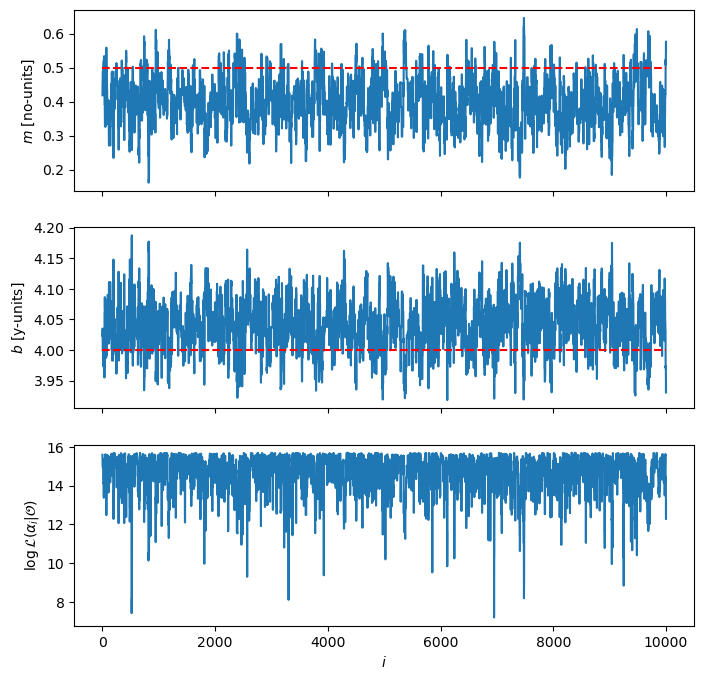

In [71]:
plot_chains(walker, my_model, true_params)

In [72]:
def plot_posterior_corner(walker):
    fig = corner.corner(
        walker.model_chain,
        labels=[p.name for p in my_model.params],
        label="posterior",
        truths=[true_params["m"], true_params["b"]],
    )
    fig.suptitle("posterior")

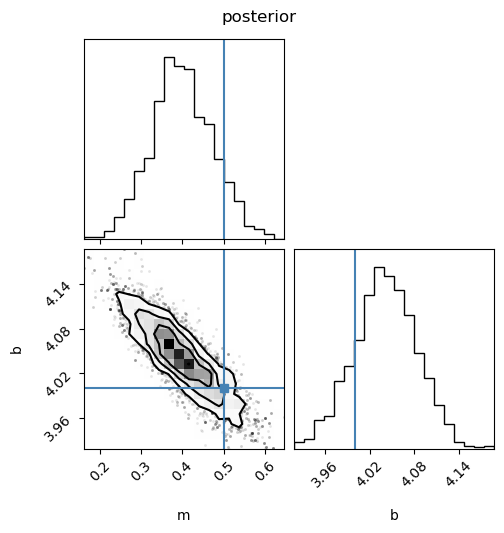

In [73]:
plot_posterior_corner(walker)

In [74]:
def plot_predictive_post(walker, model, x, y_exp, y_err, y_true):
    n_posterior_samples = walker.model_chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_chain[i, :]
        y[i, :] = model.y(x, *sample)

    upper, lower = np.percentile(y, [5, 95], axis=0)
    plt.errorbar(
        x,
        y_exp,
        y_err,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment with bias",
    )

    plt.plot(x, y_true, "k--", label="truth")
    plt.fill_between(
        x,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    return upper, lower

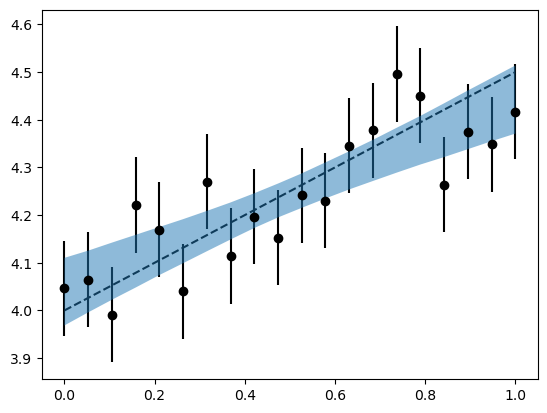

In [75]:
upper, lower = plot_predictive_post(walker, my_model, x_data, y_data, noise, y_true)